# CONFLUENCE Tutorial: Distributed Basin Workflow with Delineation

This notebook demonstrates the distributed modeling approach using the delineation method. We'll use the same Bow River at Banff location but create a distributed model with multiple GRUs (Grouped Response Units).

## Key Differences from Lumped Model

- **Domain Method**: `delineate` instead of `lumped`
- **Stream Threshold**: 5000 (creates more sub-basins)
- **Multiple GRUs**: Each sub-basin becomes a GRU
- **Routing**: mizuRoute connects the GRUs

## Learning Objectives

1. Understand watershed delineation with stream networks
2. Create a distributed model with multiple GRUs

## 1. Setup and Import Libraries

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import numpy as np
import contextily as cx
import xarray as xr
from IPython.display import Image, display

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import main CONFLUENCE class
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## 2. Initialize CONFLUENCE
First, let's set up our directories and load the configuration. We'll modify the configuration from Tutorial 1 to create a distributed model.

In [3]:
# Set directory paths
CONFLUENCE_CODE_DIR = confluence_path
CONFLUENCE_DATA_DIR = Path('/work/comphyd_lab/data/CONFLUENCE_data')  # ← User should modify this path

# Load template configuration
config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'

# Read config file
with open(config_path, 'r') as f:
    config_dict = yaml.safe_load(f)

# Update core paths
config_dict['CONFLUENCE_CODE_DIR'] = str(CONFLUENCE_CODE_DIR)
config_dict['CONFLUENCE_DATA_DIR'] = str(CONFLUENCE_DATA_DIR)

# Modify for distributed delineation
config_dict['DOMAIN_NAME'] = 'Bow_at_Banff_distributed'
config_dict['EXPERIMENT_ID'] = 'distributed_tutorial'
config_dict['DOMAIN_DEFINITION_METHOD'] = 'delineate'  # Changed from 'lumped'
config_dict['STREAM_THRESHOLD'] = 5000  # Higher threshold for fewer sub-basins
config_dict['DOMAIN_DISCRETIZATION'] = 'GRUs'  # Keep as GRUs
config_dict['SPATIAL_MODE'] = 'Distributed'  # Changed from 'Lumped'

# Save updated config to a temporary file
temp_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_distributed.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(config_dict, f)

# Initialize CONFLUENCE
confluence = CONFLUENCE(temp_config_path)

# Display configuration
print("=== Directory Configuration ===")
print(f"Code Directory: {CONFLUENCE_CODE_DIR}")
print(f"Data Directory: {CONFLUENCE_DATA_DIR}")
print("\n=== Key Configuration Settings ===")
print(f"Domain Name: {confluence.config['DOMAIN_NAME']}")
print(f"Pour Point: {confluence.config['POUR_POINT_COORDS']}")
print(f"Domain Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream Threshold: {confluence.config['STREAM_THRESHOLD']}")
print(f"Spatial Mode: {confluence.config['SPATIAL_MODE']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"Simulation Period: {confluence.config['EXPERIMENT_TIME_START']} to {confluence.config['EXPERIMENT_TIME_END']}")

09:23:41 - INFO - ============================================================


2025-05-13 09:23:41,914 - confluence_general - INFO - ============================================================


09:23:41 - INFO - CONFLUENCE Logging Initialized


2025-05-13 09:23:41,915 - confluence_general - INFO - CONFLUENCE Logging Initialized


09:23:41 - INFO - Domain: Bow_at_Banff_distributed


2025-05-13 09:23:41,917 - confluence_general - INFO - Domain: Bow_at_Banff_distributed


09:23:41 - INFO - Experiment ID: distributed_tutorial


2025-05-13 09:23:41,918 - confluence_general - INFO - Experiment ID: distributed_tutorial


09:23:41 - INFO - Log Level: INFO


2025-05-13 09:23:41,920 - confluence_general - INFO - Log Level: INFO


09:23:41 - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/confluence_general_Bow_at_Banff_distributed_20250513_092341.log


2025-05-13 09:23:41,921 - confluence_general - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/confluence_general_Bow_at_Banff_distributed_20250513_092341.log


09:23:41 - INFO - ============================================================


2025-05-13 09:23:41,923 - confluence_general - INFO - ============================================================


09:23:41 - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/config_Bow_at_Banff_distributed_20250513_092341.yaml


2025-05-13 09:23:41,945 - confluence_general - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/config_Bow_at_Banff_distributed_20250513_092341.yaml


09:23:42 - INFO - Initializing CONFLUENCE system


2025-05-13 09:23:42,012 - confluence_general - INFO - Initializing CONFLUENCE system


09:23:42 - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_distributed.yaml


2025-05-13 09:23:42,014 - confluence_general - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_distributed.yaml


09:23:42 - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


2025-05-13 09:23:42,016 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


09:23:42 - INFO - CONFLUENCE system initialized successfully


2025-05-13 09:23:42,349 - confluence_general - INFO - CONFLUENCE system initialized successfully


=== Directory Configuration ===
Code Directory: /home/darri.eythorsson/code/CONFLUENCE
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data

=== Key Configuration Settings ===
Domain Name: Bow_at_Banff_distributed
Pour Point: 51.1722/-115.5717
Domain Method: delineate
Stream Threshold: 5000
Spatial Mode: Distributed
Model: SUMMA
Simulation Period: 2018-01-01 01:00 to 2018-12-31 23:00


## 3. Project Setup - Organizing the Modeling Workflow

First, we'll establish a well-organized project structure, similar to what we did in Tutorial 1.

In [4]:
# Step 1: Project Initialization
print("=== Step 1: Project Initialization ===")

# Setup project
project_dir = confluence.managers['project'].setup_project()

# Create pour point
pour_point_path = confluence.managers['project'].create_pour_point()

# List created directories
print("\nCreated directories:")
for item in sorted(project_dir.iterdir()):
    if item.is_dir():
        print(f"  📁 {item.name}")

print("\nNote: The pour point location is identical to the lumped model.")
print("The difference is in how we subdivide the watershed above this point.")

=== Step 1: Project Initialization ===
09:23:45 - INFO - Setting up project for domain: Bow_at_Banff_distributed


2025-05-13 09:23:45,446 - confluence_general - INFO - Setting up project for domain: Bow_at_Banff_distributed


09:23:45 - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed


2025-05-13 09:23:45,481 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed
2025-05-13 09:23:45,566 - pyogrio._io - INFO - Created 1 records


09:23:45 - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp


2025-05-13 09:23:45,569 - confluence_general - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp



Created directories:
  📁 _workLog_Bow_at_Banff_distributed
  📁 attributes
  📁 documentation
  📁 forcing
  📁 observations
  📁 optimisation
  📁 plots
  📁 results
  📁 settings
  📁 shapefiles
  📁 simulations
  📁 taudem-interim-files

Note: The pour point location is identical to the lumped model.
The difference is in how we subdivide the watershed above this point.


## 4. Geospatial Domain Definition - Data Acquisition and Preparation

We'll reuse some of the geospatial data from the lumped model tutorial, where appropriate.

In [5]:
# Check if we can reuse data from the lumped model
lumped_dem_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'attributes' / 'elevation' / 'dem'
lumped_forcing_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'forcing' / 'raw_data'
can_reuse = lumped_dem_path.exists()
can_reuse_forcing = lumped_forcing_path.exists()

if can_reuse or can_reuse_forcing:
    import shutil
    
    # Create a function to copy files with name substitution
    def copy_with_name_substitution(src_path, dst_path, old_str='_lumped', new_str='_distributed'):
        if not src_path.exists():
            return False
            
        # Create destination directory if it doesn't exist
        dst_path.parent.mkdir(parents=True, exist_ok=True)
        
        if src_path.is_dir():
            # Copy entire directory
            if not dst_path.exists():
                dst_path.mkdir(parents=True, exist_ok=True)
                
            # Copy all files with name substitution
            for src_file in src_path.glob('**/*'):
                if src_file.is_file():
                    # Create relative path
                    rel_path = src_file.relative_to(src_path)
                    # Create new filename with substitution
                    new_name = src_file.name.replace(old_str, new_str)
                    # Create destination path
                    dst_file = dst_path / rel_path.parent / new_name
                    # Create parent directories if they don't exist
                    dst_file.parent.mkdir(parents=True, exist_ok=True)
                    # Copy the file
                    shutil.copy2(src_file, dst_file)
            return True
        elif src_path.is_file():
            # Copy single file with name substitution
            new_name = dst_path.name.replace(old_str, new_str)
            dst_file = dst_path.parent / new_name
            dst_file.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src_path, dst_file)
            return True
        
        return False

    print("Found existing geospatial data from lumped model. Copying and renaming files...")
    
    # Copy and rename DEM and other attribute data
    if can_reuse:
        # Define paths
        src_attr_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'attributes'
        dst_attr_path = project_dir / 'attributes'
        
        # Copy attributes with name substitution
        copied = copy_with_name_substitution(src_attr_path, dst_attr_path, '_lumped', '_distributed')
        if copied:
            print("✓ Copied and renamed attribute files from lumped model")
    
    # Copy and rename forcing data
    if can_reuse_forcing:
        # Define paths
        src_forcing_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'forcing' / 'raw_data'
        dst_forcing_path = project_dir / 'forcing' / 'raw_data'
        
        # Copy forcing data with name substitution
        copied = copy_with_name_substitution(src_forcing_path, dst_forcing_path, '_lumped', '_distributed')
        if copied:
            print("✓ Copied and renamed forcing data from lumped model")
            
    print("The distributed model will use these copied files as a starting point.")
else:
    print("No existing data found from the lumped model. Will acquire all data from scratch.")

    # Step 2: Geospatial Domain Definition - Data Acquisition
    print("\n=== Step 2: Geospatial Domain Definition - Data Acquisition ===")
    
    # Acquire attributes
    print("Acquiring geospatial attributes (DEM, soil, land cover)...")
    confluence.managers['data'].acquire_attributes()

    # Acquire forcings
    print(f"\nAcquiring forcing data: {confluence.config['FORCING_DATASET']}")
    confluence.managers['data'].acquire_forcings()
    
print("\n✓ Geospatial attributes acquired")

Found existing geospatial data from lumped model. Copying and renaming files...
✓ Copied and renamed attribute files from lumped model
✓ Copied and renamed forcing data from lumped model
The distributed model will use these copied files as a starting point.

✓ Geospatial attributes acquired


## 6. Geospatial Domain Definition - Delineation with Stream Network

This is where the main difference occurs - we'll create multiple sub-basins connected by a stream network.

In [6]:
# Step 3: Geospatial Domain Definition - Delineation
print("=== Step 3: Geospatial Domain Definition - Delineation ===")

# Define domain
print(f"Delineating distributed watershed...")
print(f"Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream threshold: {confluence.config['STREAM_THRESHOLD']}")
print("\nThis will create multiple sub-basins connected by a stream network.")

watershed_path = confluence.managers['domain'].define_domain()

# Check outputs
basin_path = project_dir / 'shapefiles' / 'river_basins'
network_path = project_dir / 'shapefiles' / 'river_network'

if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    print(f"\n✓ Created basin shapefiles: {len(basin_files)}")
    
if network_path.exists():
    network_files = list(network_path.glob('*.shp'))
    print(f"✓ Created river network shapefiles: {len(network_files)}")
    
    # Load and check number of basins
    if basin_files:
        gdf = gpd.read_file(basin_files[0])
        print(f"\nNumber of sub-basins (GRUs): {len(gdf)}")
        print(f"Total area: {gdf.geometry.area.sum() / 1e6:.2f} km²")

=== Step 3: Geospatial Domain Definition - Delineation ===
Delineating distributed watershed...
Method: delineate
Stream threshold: 5000

This will create multiple sub-basins connected by a stream network.
09:24:53 - INFO - Domain definition workflow starting with: delineate


2025-05-13 09:24:53,389 - confluence_general - INFO - Domain definition workflow starting with: delineate


09:24:53 - INFO - Starting geofabric delineation


2025-05-13 09:24:53,391 - confluence_general - INFO - Starting geofabric delineation


09:24:53 - INFO - Geofabric delineation completed successfully


2025-05-13 09:24:53,393 - confluence_general - INFO - Geofabric delineation completed successfully


09:24:53 - INFO - Starting geofabric delineation for Bow_at_Banff_distributed


2025-05-13 09:24:53,395 - confluence_general - INFO - Starting geofabric delineation for Bow_at_Banff_distributed


09:24:53 - INFO - Created interim directory: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8


2025-05-13 09:24:53,413 - confluence_general - INFO - Created interim directory: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8


09:24:53 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -v


2025-05-13 09:24:53,421 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -v


09:24:54 - INFO - Command output: On input demfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif
On input newfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif
Not Using mask file: N/A
PitRemove version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000
Header read
Process: 0, totalX: 1260, totalY: 972
Process: 0, nx: 1260, ny: 972
Process: 0, xstart: 0, ystart: 0
Data read
Midpoint of partition: 0, nxm: 630, nym: 486, value: 2002.900024
Planchon grid initialized rank: 0
Rank: 0, Stack size: 102
Rank: 0, Stack size: 100102
Rank: 0, Stack size: 200102
Rank: 0, Stack size: 30

2025-05-13 09:24:54,428 - confluence_general - INFO - Command output: On input demfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif
On input newfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif
Not Using mask file: N/A
PitRemove version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000
Header read
Process: 0, totalX: 1260, totalY: 972
Process: 0, nx: 1260, ny: 972
Process: 0, xstart: 0, ystart: 0
Data read
Midpoint of partition: 0, nxm: 630, nym: 486, value: 2002.900024
Planchon grid initialized rank: 0
Rank: 0, Stack size: 102
Rank: 0, Stack size: 100102
Rank: 0, Stack 

09:24:54 - INFO - Completed TauDEM step


2025-05-13 09:24:54,430 - confluence_general - INFO - Completed TauDEM step


09:24:54 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-sd8.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif


2025-05-13 09:24:54,433 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-sd8.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif


09:24:56 - INFO - Command output: D8FlowDir version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif has geographic coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000
Processors: 1
Header read time: 0.026093
Data read time: 0.032654
Compute Slope time: 0.290432
Write Slope time: 0.140684
Resolve Flat time: 0.709427
Write Flat time: 0.066481
Total time: 1.265771



2025-05-13 09:24:56,102 - confluence_general - INFO - Command output: D8FlowDir version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif has geographic coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000
Processors: 1
Header read time: 0.026093
Data read time: 0.032654
Compute Slope time: 0.290432
Write Slope time: 0.140684
Resolve Flat time: 0.709427
Write Flat time: 0.066481
Total time: 1.265771



09:24:56 - INFO - Completed TauDEM step


2025-05-13 09:24:56,104 - confluence_general - INFO - Completed TauDEM step


09:24:56 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -nc


2025-05-13 09:24:56,106 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -nc


09:24:56 - INFO - Command output: AreaD8 version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Number of Processes: 1
Read time: 0.034371
Compute time: 0.332990
Write time: 0.070669
Total time: 0.438031



2025-05-13 09:24:56,972 - confluence_general - INFO - Command output: AreaD8 version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Number of Processes: 1
Read time: 0.034371
Compute time: 0.332990
Write time: 0.070669
Total time: 0.438031



09:24:56 - INFO - Completed TauDEM step


2025-05-13 09:24:56,974 - confluence_general - INFO - Completed TauDEM step


09:24:56 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gridnet -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -plen /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-plen.tif -tlen /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-tlen.tif -gord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-gord.tif


2025-05-13 09:24:56,976 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gridnet -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -plen /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-plen.tif -tlen /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-tlen.tif -gord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-gord.tif


09:24:58 - INFO - Command output: GridNet version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Processors: 1
Read time: 0.042071
Compute time: 0.387922
Write time: 0.314611
Total time: 0.744603



2025-05-13 09:24:58,167 - confluence_general - INFO - Command output: GridNet version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Processors: 1
Read time: 0.042071
Compute time: 0.387922
Write time: 0.314611
Total time: 0.744603



09:24:58 - INFO - Completed TauDEM step


2025-05-13 09:24:58,169 - confluence_general - INFO - Completed TauDEM step


09:24:58 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -thresh 5000


2025-05-13 09:24:58,171 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -thresh 5000


09:24:58 - INFO - Command output: Threshold version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Compute time: 0.017513



2025-05-13 09:24:58,684 - confluence_general - INFO - Command output: Threshold version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Compute time: 0.017513



09:24:58 - INFO - Completed TauDEM step


2025-05-13 09:24:58,686 - confluence_general - INFO - Completed TauDEM step


09:24:58 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp -om /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/gauges.shp -md 200


2025-05-13 09:24:58,688 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp -om /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/gauges.shp -md 200


09:24:59 - INFO - Command output: MoveOutletsToStreams version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
gauges Total time: 0.068762



2025-05-13 09:24:59,153 - confluence_general - INFO - Command output: MoveOutletsToStreams version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
gauges Total time: 0.068762



09:24:59 - INFO - Completed TauDEM step


2025-05-13 09:24:59,155 - confluence_general - INFO - Completed TauDEM step


09:24:59 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/streamnet -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -ord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ord.tif -tree /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-tree.dat -coord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-coord.dat -net /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-

2025-05-13 09:24:59,156 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/streamnet -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -ord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ord.tif -tree /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-tree.dat -coord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-coord.dat -net /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_

09:25:00 - INFO - Command output: StreamNet version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d

2025-05-13 09:25:00,319 - confluence_general - INFO - Command output: StreamNet version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banf

09:25:00 - INFO - Completed TauDEM step


2025-05-13 09:25:00,321 - confluence_general - INFO - Completed TauDEM step


09:25:00 - INFO - Completed GDAL polygonization using direct method


/work/comphyd_lab/local/modules/spack/2024v5/core/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder/linux-rocky8-x86_64/gcc-14.2.0/gdal-3.9.2-y5bemmf6otvyodpm4zhjfqljg4ppbmnz/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
2025-05-13 09:25:00,418 - confluence_general - INFO - Completed GDAL polygonization using direct method


09:25:00 - WARNING - CRS is not defined for /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-watersheds.shp. Setting to EPSG:4326.


2025-05-13 09:25:00,441 - confluence_general - WARNING - CRS is not defined for /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-watersheds.shp. Setting to EPSG:4326.


09:25:00 - INFO - Found 20 rows with duplicate GRU_ID values


2025-05-13 09:25:00,618 - confluence_general - INFO - Found 20 rows with duplicate GRU_ID values


09:25:00 - INFO - Removed 20 duplicate GRU_IDs, keeping the largest area for each


2025-05-13 09:25:00,623 - confluence_general - INFO - Removed 20 duplicate GRU_IDs, keeping the largest area for each


09:25:00 - INFO - Remaining GRUs: 124


2025-05-13 09:25:00,624 - confluence_general - INFO - Remaining GRUs: 124


09:25:00 - INFO - Ensuring CRS consistency. Target CRS: EPSG:4326


2025-05-13 09:25:00,626 - confluence_general - INFO - Ensuring CRS consistency. Target CRS: EPSG:4326


09:25:00 - INFO - Found 7 rows with duplicate GRU_ID values


2025-05-13 09:25:00,843 - confluence_general - INFO - Found 7 rows with duplicate GRU_ID values


09:25:00 - INFO - Removed 7 duplicate GRU_IDs, keeping the largest area for each


2025-05-13 09:25:00,847 - confluence_general - INFO - Removed 7 duplicate GRU_IDs, keeping the largest area for each


09:25:00 - INFO - Remaining GRUs: 49


2025-05-13 09:25:00,849 - confluence_general - INFO - Remaining GRUs: 49
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629660964 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.78223218 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 123420378.353142783 of field GRU_area of feature 12 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/

09:25:00 - INFO - Subset basins shapefile saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/river_basins/Bow_at_Banff_distributed_riverBasins_delineate.shp


2025-05-13 09:25:00,899 - confluence_general - INFO - Subset basins shapefile saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/river_basins/Bow_at_Banff_distributed_riverBasins_delineate.shp


09:25:00 - INFO - Subset rivers shapefile saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/river_network/Bow_at_Banff_distributed_riverNetwork_delineate.shp


2025-05-13 09:25:00,901 - confluence_general - INFO - Subset rivers shapefile saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/river_network/Bow_at_Banff_distributed_riverNetwork_delineate.shp


09:25:00 - INFO - Geofabric delineation completed for Bow_at_Banff_distributed


2025-05-13 09:25:00,903 - confluence_general - INFO - Geofabric delineation completed for Bow_at_Banff_distributed


09:25:00 - INFO - Domain definition completed using method: delineate


2025-05-13 09:25:00,904 - confluence_general - INFO - Domain definition completed using method: delineate


09:25:00 - INFO - Creating domain visualization...


2025-05-13 09:25:00,906 - confluence_general - INFO - Creating domain visualization...


09:25:02 - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


2025-05-13 09:25:02,015 - confluence_general - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


09:25:02 - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


2025-05-13 09:25:02,018 - confluence_general - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


09:25:02 - INFO - Domain definition workflow finished


2025-05-13 09:25:02,019 - confluence_general - INFO - Domain definition workflow finished



✓ Created basin shapefiles: 1
✓ Created river network shapefiles: 1

Number of sub-basins (GRUs): 49
Total area: 0.00 km²


/tmp/ipykernel_1650676/1117089825.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total area: {gdf.geometry.area.sum() / 1e6:.2f} km²")


## 7. Visualize the Distributed Domain

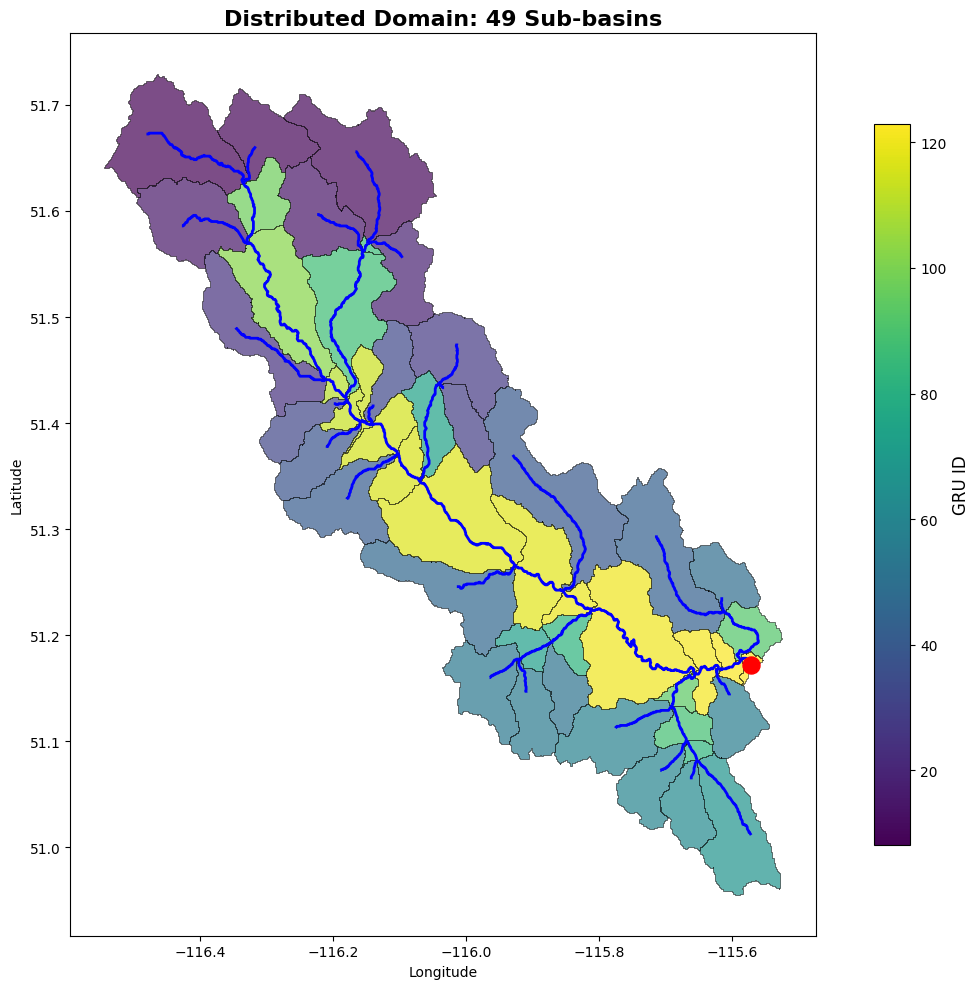

In [7]:
# Visualize the delineated domain with stream network
basin_files = list((project_dir / 'shapefiles' / 'river_basins').glob('*.shp'))
network_files = list((project_dir / 'shapefiles' / 'river_network').glob('*.shp'))
    
if basin_files and network_files:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Load data
    basins = gpd.read_file(basin_files[0])
    rivers = gpd.read_file(network_files[0])
    
    # Plot basins with different colors
    basins.plot(ax=ax, column='GRU_ID', cmap='viridis', 
               alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Plot river network
    rivers.plot(ax=ax, color='blue', linewidth=2)
    
    # Add pour point
    pour_point = gpd.read_file(pour_point_path)
    pour_point.plot(ax=ax, color='red', markersize=150, marker='o', zorder=5)
    
    ax.set_title(f'Distributed Domain: {len(basins)} Sub-basins', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add colorbar for GRU IDs
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                               norm=plt.Normalize(vmin=basins['GRU_ID'].min(), 
                                                 vmax=basins['GRU_ID'].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('GRU ID', fontsize=12)
    
    plt.tight_layout()
    plt.show()

## 8. Geospatial Domain Definition - Discretization

Now we'll create Hydrologic Response Units (HRUs) based on the Grouped Response Units (GRUs) we just created.

In [8]:
# Step 4: Geospatial Domain Definition - Discretization
print("=== Step 4: Geospatial Domain Definition - Discretization ===")

# Discretize domain
print(f"Creating HRUs based on GRUs...")
print(f"Method: {confluence.config['DOMAIN_DISCRETIZATION']}")
print("For this tutorial: 1 GRU = 1 HRU (simplest case)")

hru_path = confluence.managers['domain'].discretize_domain()

# Check the created HRU shapefile
catchment_path = project_dir / 'shapefiles' / 'catchment'
if catchment_path.exists():
    hru_files = list(catchment_path.glob('*.shp'))
    print(f"\n✓ Created HRU shapefiles: {len(hru_files)}")
    
    if hru_files:
        hru_gdf = gpd.read_file(hru_files[0])
        print(f"\nHRU Statistics:")
        print(f"Number of HRUs: {len(hru_gdf)}")
        print(f"Number of GRUs: {hru_gdf['GRU_ID'].nunique()}")
        print(f"Total area: {hru_gdf.geometry.area.sum() / 1e6:.2f} km²")
        
        # Show HRU distribution
        hru_counts = hru_gdf.groupby('GRU_ID').size()
        print(f"\nHRUs per GRU:")
        for gru_id, count in hru_counts.items():
            print(f"  GRU {gru_id}: {count} HRUs")

=== Step 4: Geospatial Domain Definition - Discretization ===
Creating HRUs based on GRUs...
Method: GRUs
For this tutorial: 1 GRU = 1 HRU (simplest case)
09:29:42 - INFO - Discretizing domain using method: GRUs


2025-05-13 09:29:42,443 - confluence_general - INFO - Discretizing domain using method: GRUs


09:29:42 - INFO - Starting domain discretization using method: grus


2025-05-13 09:29:42,446 - confluence_general - INFO - Starting domain discretization using method: grus


09:29:42 - INFO - Step 1/2: Running discretization method


2025-05-13 09:29:42,448 - confluence_general - INFO - Step 1/2: Running discretization method


09:29:42 - INFO - config domain name Bow_at_Banff_distributed


2025-05-13 09:29:42,450 - confluence_general - INFO - config domain name Bow_at_Banff_distributed


09:29:42 - INFO - Calculating mean elevation for each HRU


2025-05-13 09:29:42,459 - confluence_general - INFO - Calculating mean elevation for each HRU
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/home/darri.eythorsson/code/CONFLUENCE/utils/geospatial/discretization_utils.py:180: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_utm = gru_gdf.geometry.centroid
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629660964 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages

09:29:42 - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment/Bow_at_Banff_distributed_HRUs_GRUs.shp


2025-05-13 09:29:42,783 - confluence_general - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment/Bow_at_Banff_distributed_HRUs_GRUs.shp


09:29:43 - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/catchment/Bow_at_Banff_distributed_HRUs_as_GRUs.png


2025-05-13 09:29:43,690 - confluence_general - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/catchment/Bow_at_Banff_distributed_HRUs_as_GRUs.png


09:29:43 - INFO - Step 2/2: Sorting catchment shape


2025-05-13 09:29:43,692 - confluence_general - INFO - Step 2/2: Sorting catchment shape


09:29:43 - INFO - Sorting catchment shape


2025-05-13 09:29:43,694 - confluence_general - INFO - Sorting catchment shape
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629660964 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629660964 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.78223218 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_d

09:29:43 - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment/Bow_at_Banff_distributed_HRUs_GRUs.shp


2025-05-13 09:29:43,731 - confluence_general - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment/Bow_at_Banff_distributed_HRUs_GRUs.shp


09:29:43 - INFO - Domain discretization completed in 1.29 seconds


2025-05-13 09:29:43,733 - confluence_general - INFO - Domain discretization completed in 1.29 seconds


09:29:43 - ERROR - Domain discretization failed - no shapefile created


2025-05-13 09:29:43,734 - confluence_general - ERROR - Domain discretization failed - no shapefile created



✓ Created HRU shapefiles: 1

HRU Statistics:
Number of HRUs: 49
Number of GRUs: 49
Total area: 0.00 km²

HRUs per GRU:
  GRU 8: 1 HRUs
  GRU 9: 1 HRUs
  GRU 10: 1 HRUs
  GRU 14: 1 HRUs
  GRU 15: 1 HRUs
  GRU 18: 1 HRUs
  GRU 24: 1 HRUs
  GRU 27: 1 HRUs
  GRU 29: 1 HRUs
  GRU 32: 1 HRUs
  GRU 33: 1 HRUs
  GRU 38: 1 HRUs
  GRU 39: 1 HRUs
  GRU 41: 1 HRUs
  GRU 43: 1 HRUs
  GRU 46: 1 HRUs
  GRU 48: 1 HRUs
  GRU 52: 1 HRUs
  GRU 53: 1 HRUs
  GRU 55: 1 HRUs
  GRU 56: 1 HRUs
  GRU 58: 1 HRUs
  GRU 60: 1 HRUs
  GRU 62: 1 HRUs
  GRU 67: 1 HRUs
  GRU 72: 1 HRUs
  GRU 74: 1 HRUs
  GRU 82: 1 HRUs
  GRU 83: 1 HRUs
  GRU 86: 1 HRUs
  GRU 87: 1 HRUs
  GRU 88: 1 HRUs
  GRU 92: 1 HRUs
  GRU 94: 1 HRUs
  GRU 97: 1 HRUs
  GRU 102: 1 HRUs
  GRU 110: 1 HRUs
  GRU 111: 1 HRUs
  GRU 113: 1 HRUs
  GRU 114: 1 HRUs
  GRU 115: 1 HRUs
  GRU 116: 1 HRUs
  GRU 117: 1 HRUs
  GRU 118: 1 HRUs
  GRU 119: 1 HRUs
  GRU 120: 1 HRUs
  GRU 121: 1 HRUs
  GRU 122: 1 HRUs
  GRU 123: 1 HRUs


/tmp/ipykernel_1650676/2701407536.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total area: {hru_gdf.geometry.area.sum() / 1e6:.2f} km²")


## 9. Model Agnostic Data Processing - Observed Data

The observed streamflow data will be the same for both the lumped and distributed models since they use the same pour point.

=== Step 5: Model Agnostic Data Processing - Observed Data ===
Found existing observed data from lumped model. Reusing...
Processing observed streamflow data...
09:29:49 - INFO - Processing observed data


2025-05-13 09:29:49,937 - confluence_general - INFO - Processing observed data


09:29:49 - INFO - Processing WSC streamflow data from HYDAT database


2025-05-13 09:29:49,939 - confluence_general - INFO - Processing WSC streamflow data from HYDAT database


09:29:49 - INFO - Querying data from year 2018 to 2025


2025-05-13 09:29:49,943 - confluence_general - INFO - Querying data from year 2018 to 2025


09:29:49 - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database


2025-05-13 09:29:49,945 - confluence_general - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database


09:29:49 - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3


2025-05-13 09:29:49,946 - confluence_general - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3


09:29:49 - INFO - Time period: 2018 to 2025


2025-05-13 09:29:49,948 - confluence_general - INFO - Time period: 2018 to 2025


09:29:49 - INFO - Found station 05BB001 in HYDAT database


2025-05-13 09:29:49,962 - confluence_general - INFO - Found station 05BB001 in HYDAT database


09:29:49 - INFO - Station name: BOW RIVER AT BANFF


2025-05-13 09:29:49,963 - confluence_general - INFO - Station name: BOW RIVER AT BANFF


09:29:49 - INFO - Executing SQL query for daily flows...


2025-05-13 09:29:49,965 - confluence_general - INFO - Executing SQL query for daily flows...


09:29:49 - INFO - Retrieved 72 monthly records from HYDAT


2025-05-13 09:29:49,988 - confluence_general - INFO - Retrieved 72 monthly records from HYDAT


09:29:50 - INFO - Processed 2191 daily flow records


2025-05-13 09:29:50,073 - confluence_general - INFO - Processed 2191 daily flow records


09:29:50 - INFO - Date range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00


2025-05-13 09:29:50,075 - confluence_general - INFO - Date range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00


09:29:50 - INFO - Min flow: 5.809999942779541 m³/s


2025-05-13 09:29:50,076 - confluence_general - INFO - Min flow: 5.809999942779541 m³/s


09:29:50 - INFO - Max flow: 240.0 m³/s


2025-05-13 09:29:50,078 - confluence_general - INFO - Max flow: 240.0 m³/s


09:29:50 - INFO - Mean flow: 38.202441793769964 m³/s


2025-05-13 09:29:50,080 - confluence_general - INFO - Mean flow: 38.202441793769964 m³/s


09:29:50 - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/observations/streamflow/preprocessed/Bow_at_Banff_distributed_streamflow_processed.csv


2025-05-13 09:29:50,996 - confluence_general - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/observations/streamflow/preprocessed/Bow_at_Banff_distributed_streamflow_processed.csv


09:29:50 - INFO - Total rows in processed data: 52561


2025-05-13 09:29:50,998 - confluence_general - INFO - Total rows in processed data: 52561


09:29:51 - INFO - Number of non-null values: 52561


2025-05-13 09:29:51,000 - confluence_general - INFO - Number of non-null values: 52561


09:29:51 - INFO - Number of null values: 0


2025-05-13 09:29:51,002 - confluence_general - INFO - Number of null values: 0


09:29:51 - INFO - Successfully processed WSC data for station 05BB001


2025-05-13 09:29:51,011 - confluence_general - INFO - Successfully processed WSC data for station 05BB001


09:29:51 - INFO - Processing SNOTEL data


2025-05-13 09:29:51,013 - confluence_general - INFO - Processing SNOTEL data


09:29:51 - INFO - SNOTEL data processing is disabled in configuration


2025-05-13 09:29:51,015 - confluence_general - INFO - SNOTEL data processing is disabled in configuration


09:29:51 - INFO - Observed data processing completed successfully


2025-05-13 09:29:51,017 - confluence_general - INFO - Observed data processing completed successfully


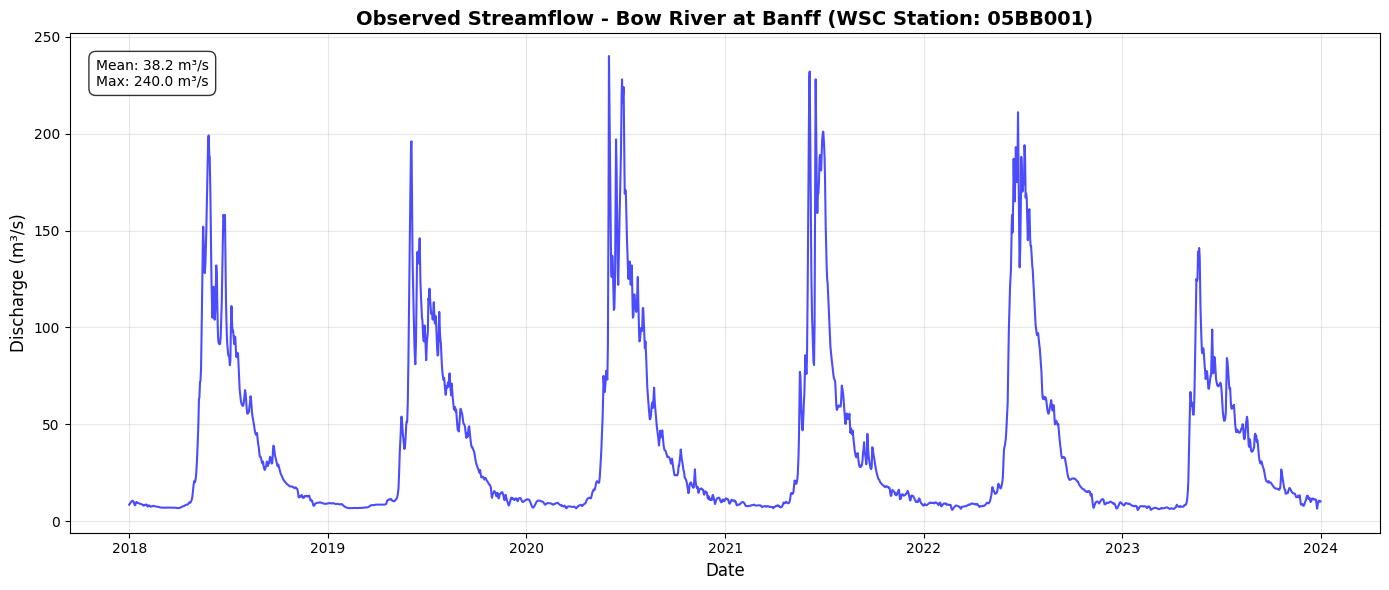

In [9]:
# Step 5: Model Agnostic Data Processing - Observed Data
print("=== Step 5: Model Agnostic Data Processing - Observed Data ===")

# Check if we can reuse data from the lumped model
lumped_obs_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'observations' / 'streamflow' / 'preprocessed'
can_reuse_obs = lumped_obs_path.exists() and list(lumped_obs_path.glob('*.csv'))

if can_reuse_obs:
    print("Found existing observed data from lumped model. Reusing...")
    # We can proceed, but CONFLUENCE will handle the reuse internally

# Process observed data
print("Processing observed streamflow data...")
confluence.managers['data'].process_observed_data()

# Visualize observed streamflow data
obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
if obs_path.exists():
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
            linewidth=1.5, color='blue', alpha=0.7)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Discharge (m³/s)', fontsize=12)
    ax.set_title(f'Observed Streamflow - Bow River at Banff (WSC Station: {confluence.config["STATION_ID"]})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    ax.text(0.02, 0.95, f'Mean: {obs_df["discharge_cms"].mean():.1f} m³/s\nMax: {obs_df["discharge_cms"].max():.1f} m³/s', 
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

## 10. Model Agnostic Data Processing - Preprocessing

In [ ]:
# Step 7: Model Agnostic Data Processing - Preprocessing
print("=== Step 7: Model Agnostic Data Processing - Preprocessing ===")

# Run model-agnostic preprocessing
print("\nRunning model-agnostic preprocessing...")
confluence.managers['data'].run_model_agnostic_preprocessing()

print("\n✓ Model-agnostic preprocessing completed")

## 11. Model-Specific Processing - Preprocessing

Now we prepare inputs specific to our chosen hydrological model (SUMMA in this case), set up for a distributed configuration.

In [ ]:
# Step 8: Model Specific Processing and Initialization
print("=== Step 8: Model Specific Processing and Initialization ===")

# Preprocess models
print(f"Preparing {confluence.config['HYDROLOGICAL_MODEL']} input files...")
print(f"Note: For distributed mode with {confluence.config['HYDROLOGICAL_MODEL']}, this includes generating:")
print(f"  - Model parameter files for each GRU")
print(f"  - Routing configuration for river network")

confluence.managers['model'].preprocess_models()

print("\n✓ Model-specific preprocessing completed")

## 13. Run the Distributed Model

Now we execute the SUMMA model in distributed mode with routing.

In [ ]:
# Step 9: Run the Distributed Model
print("=== Step 9: Run the Distributed Model ===")

# Run the model
print(f"Running distributed {confluence.config['HYDROLOGICAL_MODEL']} model...")
print(f"Number of GRUs: (check from previous output)")
print("Note: This will take longer than the lumped model due to multiple units.")

confluence.managers['model'].run_models()

print("\n✓ Model execution completed")

=== Step 9: Run the Distributed Model ===
Running distributed SUMMA model...
Number of GRUs: (check from previous output)
Note: This will take longer than the lumped model due to multiple units.
09:30:03 - INFO - Starting model runs


2025-05-13 09:30:03,413 - confluence_general - INFO - Starting model runs


09:30:03 - INFO - Running model: SUMMA


2025-05-13 09:30:03,416 - confluence_general - INFO - Running model: SUMMA


09:30:03 - INFO - Starting SUMMA run


2025-05-13 09:30:03,417 - confluence_general - INFO - Starting SUMMA run


## 15. Visualize Distributed Model Results

In [ ]:
# Postprocess results and visualize
print("Visualising model results...")

# Load and plot simulation results
sim_path = project_dir / 'simulations' / confluence.config['EXPERIMENT_ID'] / 'mizuRoute'
sim_files = list(sim_path.glob('*.nc'))

if sim_files:
    # Load simulation data
    sim_data = xr.open_dataset(sim_files[0])
    
    # Load observation data
    obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    
    # Find the segment ID for the outlet
    if 'reachID' in sim_data.dims:
        outlet_idx = sim_data.reachID.values == confluence.config['SIM_REACH_ID']
        if any(outlet_idx):
            # Extract simulated flow at outlet
            sim_flow = sim_data.IRFroutedRunoff.sel(reachID=confluence.config['SIM_REACH_ID']).to_pandas()
            sim_df = pd.DataFrame({'datetime': sim_flow.index, 'flow': sim_flow.values})
            
            # Plot comparison
            fig, ax = plt.subplots(figsize=(14, 6))
            
            # Plot observed flow
            ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
                    color='blue', linewidth=1.5, label='Observed')
            
            # Plot simulated flow
            ax.plot(sim_df['datetime'], sim_df['flow'], 
                    color='red', linewidth=1.5, alpha=0.7, label='Simulated (Distributed)')
            
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Discharge (m³/s)', fontsize=12)
            ax.set_title('Distributed Model Results - Bow River at Banff', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
    else:
        print("Could not find reachID dimension in simulation output")
else:
    print("No simulation results found. Check model execution.")

## 16. Compare Lumped vs Distributed Results (Optional)

If you've completed the lumped model tutorial, we can compare results between the two approaches.

In [ ]:
# Try to load lumped model results for comparison
lumped_sim_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'simulations' / 'run_1' / 'mizuRoute'
lumped_sim_files = list(lumped_sim_path.glob('*.nc')) if lumped_sim_path.exists() else []

if lumped_sim_files:
    print("Found lumped model results. Creating comparison plot...")
    
    # Load lumped simulation data
    lumped_data = xr.open_dataset(lumped_sim_files[0])
    
    # Load distributed simulation data
    dist_sim_path = project_dir / 'simulations' / confluence.config['EXPERIMENT_ID'] / 'mizuRoute'
    dist_sim_files = list(dist_sim_path.glob('*.nc'))
    
    if dist_sim_files:
        dist_data = xr.open_dataset(dist_sim_files[0])
        
        # Load observation data
        obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
        obs_df = pd.read_csv(obs_path)
        obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
        
        # Extract flows
        # Find the segment ID for the outlet
        if 'reachID' in dist_data.dims and 'reachID' in lumped_data.dims:
            # Extract distributed flow
            dist_flow = dist_data.IRFroutedRunoff.sel(reachID=confluence.config['SIM_REACH_ID']).to_pandas()
            dist_df = pd.DataFrame({'datetime': dist_flow.index, 'flow': dist_flow.values})
            
            # Extract lumped flow
            lumped_flow = lumped_data.IRFroutedRunoff.sel(reachID=confluence.config['SIM_REACH_ID']).to_pandas()
            lumped_df = pd.DataFrame({'datetime': lumped_flow.index, 'flow': lumped_flow.values})
            
            # Plot comparison
            fig, ax = plt.subplots(figsize=(14, 6))
            
            # Plot observed flow
            ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
                    color='black', linewidth=1.5, label='Observed')
            
            # Plot lumped flow
            ax.plot(lumped_df['datetime'], lumped_df['flow'], 
                    color='blue', linewidth=1.5, alpha=0.7, label='Lumped Model')
            
            # Plot distributed flow
            ax.plot(dist_df['datetime'], dist_df['flow'], 
                    color='red', linewidth=1.5, alpha=0.7, label='Distributed Model')
            
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Discharge (m³/s)', fontsize=12)
            ax.set_title('Lumped vs Distributed Model Comparison - Bow River at Banff', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
    else:
        print("Distributed simulation results not found. Run the distributed model first.")
else:
    print("Lumped model results not found. Complete Tutorial 2 first for comparison.")

## 17. Optional Steps - Optimization and Analysis

These steps are optional and could be run to further explore the distributed model.

In [ ]:
# Step 11: Optional Steps (Optimization and Analysis)
print("=== Step 11: Optional Steps ===")

# Check if optimization is enabled
if confluence.config.get('RUN_ITERATIVE_OPTIMISATION', False):
    print("Running model calibration...")
    optimization_results = confluence.managers['optimization'].calibrate_model()
else:
    print("Model calibration skipped (RUN_ITERATIVE_OPTIMISATION = False)")

# Check if emulation is enabled
if confluence.config.get('RUN_LARGE_SAMPLE_EMULATION', False) or confluence.config.get('RUN_RANDOM_FOREST_EMULATION', False):
    print("Running parameter emulation...")
    emulation_results = confluence.managers['optimization'].run_emulation()
else:
    print("Parameter emulation skipped")

# Check if decision analysis is enabled
if confluence.config.get('RUN_DECISION_ANALYSIS', False):
    print("Running decision analysis...")
    decision_results = confluence.managers['analysis'].run_decision_analysis()
else:
    print("Decision analysis skipped")

# Check if sensitivity analysis is enabled
if confluence.config.get('RUN_SENSITIVITY_ANALYSIS', False):
    print("Running sensitivity analysis...")
    sensitivity_results = confluence.managers['analysis'].run_sensitivity_analysis()
else:
    print("Sensitivity analysis skipped")

In [ ]:
# Alternative: Run the complete workflow in one step
# (Uncomment to use this instead of the step-by-step approach)

# confluence.run_workflow()